In [48]:
import numpy as np
import uproot
import pandas as pd
import awkward as ak
from tqdm import tqdm

In [49]:
with uproot.open('atmospherics_prod_1M_events_cafs_hadd_with_weights.root') as f:
    weights = f['weights'].arrays(library='pd')
    weights['nuPDG'] = ak.flatten(f['cafTree/rec/mc/mc.nu.pdg'].array())
    weights['Ev'] = ak.flatten(f['cafTree/rec/mc/mc.nu.E'].array())
    weights['NuMomX'] = ak.flatten(f['cafTree/rec/mc/mc.nu.momentum.x'].array())
    weights['NuMomY'] = ak.flatten(f['cafTree/rec/mc/mc.nu.momentum.y'].array())
    weights['NuMomZ'] = ak.flatten(f['cafTree/rec/mc/mc.nu.momentum.z'].array())
    weights['coszen'] = weights['NuMomY'] / np.sqrt(weights['NuMomX']**2 + weights['NuMomY']**2 + weights['NuMomZ']**2)

    weights['nue_unosc_w'] = weights['xsec'] * weights['nue_w']
    weights['numu_unosc_w'] = weights['xsec'] * weights['numu_w']
df = weights

In [50]:
#Get OscProb
import ROOT
ROOT.gSystem.Load('/home/seave/anaconda3/OscProb/lib/libOscProb.so')

1

In [51]:
def ConfigurePMNS(mh):
    
    myPMNS = ROOT.OscProb.PMNS_NSI()
    prem = ROOT.OscProb.PremModel()

    # Set basic oscillation parameters (Best fit as of 2024)
    dm21 = 7.49e-5
    dm31 = 2.513e-3 if mh > 0 else -2.510e-3
    th12 = np.arcsin(np.sqrt(0.308))
    th13 = np.arcsin(np.sqrt(0.02215)) if mh > 0 else np.arcsin(np.sqrt(0.02224));
    th23 = np.arcsin(np.sqrt(0.470)) if mh > 0 else np.arcsin(np.sqrt(0.562));
    dcp = 212*(np.pi/180) if mh> 0 else 285*(np.pi/180)

    myPMNS.SetMix(th12, th23, th13, dcp);
    myPMNS.SetDeltaMsqrs(dm21, dm31); 

    return myPMNS, prem

In [84]:
def Get_Prob(E, coszen, mh, flav_in, flav_out, nsiDict, is_antinu):
  
  myPMNS, prem = ConfigurePMNS(mh)
    
  if is_antinu:
    myPMNS.SetIsNuBar(True)
  #Set epsilon and delta values to given nsi param
  
  if nsiDict is None:    
    # Explicitly zero NSI
    myPMNS.SetEps_emu(0.0, 0.0)
    myPMNS.SetEps_etau(0.0, 0.0)
    myPMNS.SetEps_mutau(0.0, 0.0)
  
  else:
      nsi_param = list(nsiDict.keys())[0]
      epsilon, delta = nsiDict[nsi_param] 
      
      if nsi_param == 'eps_emu':
          myPMNS.SetEps_emu(epsilon, delta)
      elif nsi_param == 'eps_etau':
          myPMNS.SetEps_etau(epsilon, delta)
      elif nsi_param == 'eps_mutau':
          myPMNS.SetEps_mutau(epsilon, delta)
      else:
          print("Invalid NSI Parameter")

  #Get total length of path and set path through earth
  L = prem.GetTotalL(coszen)
  prem.FillPath(coszen);
  myPMNS.SetPath(prem.GetNuPath());

  prob =  myPMNS.Prob(flav_in, flav_out, L/E)
  return prob

In [85]:
def Get_Expected(df, mh, flav_out, nsiDict):
    total_weighted = 0.0
    
    for _, row in df.iterrows():
        E = row['Ev']
        cz = row['coszen']
        nu_pdg = row['nuPDG']
        is_antinu = (nu_pdg < 0)
        flav_in = abs(nu_pdg)  # Use 12, 14, 16 for ν_e, ν_μ, ν_τ

        # Pick the correct unoscillated weight
        if flav_in == 12:  # ν_e or ν̄_e
            weight = row['nue_unosc_w']
            flav_in_code = 0
        elif flav_in == 14:  # ν_μ or ν̄_μ
            weight = row['numu_unosc_w']
            flav_in_code = 1
        else:
            continue 

        # Compute oscillation probability
        prob = Get_Prob(
            E, cz, mh,
            flav_in_code, flav_out,
            nsiDict,
            is_antinu
        )
        total_weighted += weight * prob

    return total_weighted


In [86]:
def Make_NSI_Dict(eps_name, eps_val, delta):
    nsiDict = {eps_name: [eps_val, delta]}
    return nsiDict

In [120]:
def RandomSampling(df):
    # the seed can be whatever we choose, 1 is used here 
    df_random = df.sample(n = 10000, random_state = 1)
    return df_random

In [122]:
#Get progress bar, will likely take some time
from tqdm import tqdm

eps_vals = np.linspace(0.05, 2, 20)
delta_vals = np.linspace(0, 2*np.pi, 20)
chi2_map = np.zeros((len(eps_vals), len(delta_vals)))

mh = +1  # or -1 for inverted hierarchy
flav_out = 1  # observed flavor (e.g., νμ)
df_rand = RandomSampling(df)

# Compute standard events
N_std = Get_Expected(df_rand, mh, flav_out, nsiDict = None)
print(N_std)
# Scan grid

for i, eps in enumerate(tqdm(eps_vals, desc="Scanning ε")):
    for j, delta in enumerate(delta_vals):
        
        nsiDict = Make_NSI_Dict("eps_emu", eps, delta)
        print(nsiDict)
        N_nsi = Get_Expected(df_rand, mh, flav_out, nsiDict)
        print(N_nsi)
        chi2_map[i, j] = ((N_nsi - N_std)**2) / (N_std)

3500.3563830425305


Scanning ε:   0%|                                                                                | 0/20 [00:00<?, ?it/s]

{'eps_emu': [0.05, 0.0]}
3495.751571362434
{'eps_emu': [0.05, 0.3306939635357677]}
3495.744006371342
{'eps_emu': [0.05, 0.6613879270715354]}
3495.7350106736853
{'eps_emu': [0.05, 0.992081890607303]}
3495.7255726586905
{'eps_emu': [0.05, 1.3227758541430708]}
3495.7167191692592
{'eps_emu': [0.05, 1.6534698176788385]}
3495.709402511536
{'eps_emu': [0.05, 1.984163781214606]}
3495.704400261186
{'eps_emu': [0.05, 2.3148577447503738]}
3495.7022374516864
{'eps_emu': [0.05, 2.6455517082861415]}
3495.7031368571065
{'eps_emu': [0.05, 2.9762456718219092]}
3495.7069997358635
{'eps_emu': [0.05, 3.306939635357677]}
3495.71341706862
{'eps_emu': [0.05, 3.6376335988934447]}
3495.7217098466367
{'eps_emu': [0.05, 3.968327562429212]}
3495.730995740599
{'eps_emu': [0.05, 4.29902152596498]}
3495.7402778335327
{'eps_emu': [0.05, 4.6297154895007475]}
3495.7485487023796
{'eps_emu': [0.05, 4.960409453036515]}
3495.754900239585
{'eps_emu': [0.05, 5.291103416572283]}
3495.7586270462916
{'eps_emu': [0.05, 5.6217973

Scanning ε:   5%|███▌                                                                    | 1/20 [00:26<08:20, 26.33s/it]

3495.751571362433
{'eps_emu': [0.15263157894736842, 0.0]}
3460.1551438596416
{'eps_emu': [0.15263157894736842, 0.3306939635357677]}
3460.1340216327794
{'eps_emu': [0.15263157894736842, 0.6613879270715354]}
3460.1091564799153
{'eps_emu': [0.15263157894736842, 0.992081890607303]}
3460.083357299413
{'eps_emu': [0.15263157894736842, 1.3227758541430708]}
3460.059453922292
{'eps_emu': [0.15263157894736842, 1.6534698176788385]}
3460.03997626254
{'eps_emu': [0.15263157894736842, 1.984163781214606]}
3460.0269057738797
{'eps_emu': [0.15263157894736842, 2.3148577447503738]}
3460.021515216986
{'eps_emu': [0.15263157894736842, 2.6455517082861415]}
3460.0242911434016
{'eps_emu': [0.15263157894736842, 2.9762456718219092]}
3460.0349221691554
{'eps_emu': [0.15263157894736842, 3.306939635357677]}
3460.052337158882
{'eps_emu': [0.15263157894736842, 3.6376335988934447]}
3460.0747873247183
{'eps_emu': [0.15263157894736842, 3.968327562429212]}
3460.0999775457362
{'eps_emu': [0.15263157894736842, 4.299021525

Scanning ε:  10%|███████▏                                                                | 2/20 [00:39<05:29, 18.31s/it]

3460.1551438596416
{'eps_emu': [0.25526315789473686, 0.0]}
3401.925722086381
{'eps_emu': [0.25526315789473686, 0.3306939635357677]}
3401.89731625822
{'eps_emu': [0.25526315789473686, 0.6613879270715354]}
3401.8645126666925
{'eps_emu': [0.25526315789473686, 0.992081890607303]}
3401.8311429862138
{'eps_emu': [0.25526315789473686, 1.3227758541430708]}
3401.80090513816
{'eps_emu': [0.25526315789473686, 1.6534698176788385]}
3401.7769286186185
{'eps_emu': [0.25526315789473686, 1.984163781214606]}
3401.761497875268
{'eps_emu': [0.25526315789473686, 2.3148577447503738]}
3401.755936994629
{'eps_emu': [0.25526315789473686, 2.6455517082861415]}
3401.7606125210955
{'eps_emu': [0.25526315789473686, 2.9762456718219092]}
3401.7749928359212
{'eps_emu': [0.25526315789473686, 3.306939635357677]}
3401.7977162565694
{'eps_emu': [0.25526315789473686, 3.6376335988934447]}
3401.8266560793695
{'eps_emu': [0.25526315789473686, 3.968327562429212]}
3401.8590099612197
{'eps_emu': [0.25526315789473686, 4.299021525

Scanning ε:  15%|██████████▊                                                             | 3/20 [00:58<05:17, 18.67s/it]

3401.925722086381
{'eps_emu': [0.35789473684210527, 0.0]}
3344.0857775166887
{'eps_emu': [0.35789473684210527, 0.3306939635357677]}
3344.060869898303
{'eps_emu': [0.35789473684210527, 0.6613879270715354]}
3344.033597597051
{'eps_emu': [0.35789473684210527, 0.992081890607303]}
3344.0073690915497
{'eps_emu': [0.35789473684210527, 1.3227758541430708]}
3343.9851596231565
{'eps_emu': [0.35789473684210527, 1.6534698176788385]}
3343.9691334730337
{'eps_emu': [0.35789473684210527, 1.984163781214606]}
3343.960512180302
{'eps_emu': [0.35789473684210527, 2.3148577447503738]}
3343.959659231602
{'eps_emu': [0.35789473684210527, 2.6455517082861415]}
3343.9662807122554
{'eps_emu': [0.35789473684210527, 2.9762456718219092]}
3343.9796195294716
{'eps_emu': [0.35789473684210527, 3.306939635357677]}
3343.9985541399838
{'eps_emu': [0.35789473684210527, 3.6376335988934447]}
3344.0215840339065
{'eps_emu': [0.35789473684210527, 3.968327562429212]}
3344.046760467426
{'eps_emu': [0.35789473684210527, 4.29902152

Scanning ε:  20%|██████████████▍                                                         | 4/20 [01:17<05:00, 18.79s/it]

3344.085777516689
{'eps_emu': [0.4605263157894737, 0.0]}
3292.052828353974
{'eps_emu': [0.4605263157894737, 0.3306939635357677]}
3292.022561907731
{'eps_emu': [0.4605263157894737, 0.6613879270715354]}
3291.9890636527625
{'eps_emu': [0.4605263157894737, 0.992081890607303]}
3291.956508737908
{'eps_emu': [0.4605263157894737, 1.3227758541430708]}
3291.9285836208855
{'eps_emu': [0.4605263157894737, 1.6534698176788385]}
3291.908019855035
{'eps_emu': [0.4605263157894737, 1.984163781214606]}
3291.896422089239
{'eps_emu': [0.4605263157894737, 2.3148577447503738]}
3291.8943569062917
{'eps_emu': [0.4605263157894737, 2.6455517082861415]}
3291.9015824625985
{'eps_emu': [0.4605263157894737, 2.9762456718219092]}
3291.9172713070707
{'eps_emu': [0.4605263157894737, 3.306939635357677]}
3291.940118986093
{'eps_emu': [0.4605263157894737, 3.6376335988934447]}
3291.968318484654
{'eps_emu': [0.4605263157894737, 3.968327562429212]}
3291.9994738145638
{'eps_emu': [0.4605263157894737, 4.29902152596498]}
3292.03

Scanning ε:  25%|██████████████████                                                      | 5/20 [01:36<04:46, 19.08s/it]

3292.0528283539743
{'eps_emu': [0.5631578947368422, 0.0]}
3235.2941951241583
{'eps_emu': [0.5631578947368422, 0.3306939635357677]}
3235.250405478638
{'eps_emu': [0.5631578947368422, 0.6613879270715354]}
3235.200061070235
{'eps_emu': [0.5631578947368422, 0.992081890607303]}
3235.1492377855993
{'eps_emu': [0.5631578947368422, 1.3227758541430708]}
3235.1036228336734
{'eps_emu': [0.5631578947368422, 1.6534698176788385]}
3235.0678224851868
{'eps_emu': [0.5631578947368422, 1.984163781214606]}
3235.045004188038
{'eps_emu': [0.5631578947368422, 2.3148577447503738]}
3235.036853114878
{'eps_emu': [0.5631578947368422, 2.6455517082861415]}
3235.0437220644967
{'eps_emu': [0.5631578947368422, 2.9762456718219092]}
3235.0648178189076
{'eps_emu': [0.5631578947368422, 3.306939635357677]}
3235.098308047333
{'eps_emu': [0.5631578947368422, 3.6376335988934447]}
3235.141327992047
{'eps_emu': [0.5631578947368422, 3.968327562429212]}
3235.18996780748
{'eps_emu': [0.5631578947368422, 4.29902152596498]}
3235.23

Scanning ε:  30%|█████████████████████▌                                                  | 6/20 [01:56<04:29, 19.22s/it]

3235.294195124161
{'eps_emu': [0.6657894736842106, 0.0]}
3189.9842490319834
{'eps_emu': [0.6657894736842106, 0.3306939635357677]}
3189.959189514903
{'eps_emu': [0.6657894736842106, 0.6613879270715354]}
3189.932911362556
{'eps_emu': [0.6657894736842106, 0.992081890607303]}
3189.9089273396285
{'eps_emu': [0.6657894736842106, 1.3227758541430708]}
3189.8900218167673
{'eps_emu': [0.6657894736842106, 1.6534698176788385]}
3189.877874171062
{'eps_emu': [0.6657894736842106, 1.984163781214606]}
3189.873034648993
{'eps_emu': [0.6657894736842106, 2.3148577447503738]}
3189.875187052515
{'eps_emu': [0.6657894736842106, 2.6455517082861415]}
3189.883534812666
{'eps_emu': [0.6657894736842106, 2.9762456718219092]}
3189.8971226052076
{'eps_emu': [0.6657894736842106, 3.306939635357677]}
3189.9149611905505
{'eps_emu': [0.6657894736842106, 3.6376335988934447]}
3189.9359329750628
{'eps_emu': [0.6657894736842106, 3.968327562429212]}
3189.958571892849
{'eps_emu': [0.6657894736842106, 4.29902152596498]}
3189.98

Scanning ε:  35%|█████████████████████████▏                                              | 7/20 [02:16<04:15, 19.64s/it]

3189.9842490319816
{'eps_emu': [0.768421052631579, 0.0]}
3149.003968857059
{'eps_emu': [0.768421052631579, 0.3306939635357677]}
3148.980233395513
{'eps_emu': [0.768421052631579, 0.6613879270715354]}
3148.9556912046964
{'eps_emu': [0.768421052631579, 0.992081890607303]}
3148.9337076972347
{'eps_emu': [0.768421052631579, 1.3227758541430708]}
3148.9168604619017
{'eps_emu': [0.768421052631579, 1.6534698176788385]}
3148.9065815509593
{'eps_emu': [0.768421052631579, 1.984163781214606]}
3148.9031710567056
{'eps_emu': [0.768421052631579, 2.3148577447503738]}
3148.906106974113
{'eps_emu': [0.768421052631579, 2.6455517082861415]}
3148.9144742814397
{'eps_emu': [0.768421052631579, 2.9762456718219092]}
3148.927312736428
{'eps_emu': [0.768421052631579, 3.306939635357677]}
3148.943743425043
{'eps_emu': [0.768421052631579, 3.6376335988934447]}
3148.9628509025497
{'eps_emu': [0.768421052631579, 3.968327562429212]}
3148.9834210755894
{'eps_emu': [0.768421052631579, 4.29902152596498]}
3149.0037125569334

Scanning ε:  40%|████████████████████████████▊                                           | 8/20 [02:37<03:58, 19.87s/it]

3149.0039688570596
{'eps_emu': [0.8710526315789474, 0.0]}
3150.8749097745895
{'eps_emu': [0.8710526315789474, 0.3306939635357677]}
3150.8681164950967
{'eps_emu': [0.8710526315789474, 0.6613879270715354]}
3150.8651290138205
{'eps_emu': [0.8710526315789474, 0.992081890607303]}
3150.867015642659
{'eps_emu': [0.8710526315789474, 1.3227758541430708]}
3150.8737693956928
{'eps_emu': [0.8710526315789474, 1.6534698176788385]}
3150.8842340423043
{'eps_emu': [0.8710526315789474, 1.984163781214606]}
3150.8964151335485
{'eps_emu': [0.8710526315789474, 2.3148577447503738]}
3150.9080579578467
{'eps_emu': [0.8710526315789474, 2.6455517082861415]}
3150.917278290479
{'eps_emu': [0.8710526315789474, 2.9762456718219092]}
3150.923021606458
{'eps_emu': [0.8710526315789474, 3.306939635357677]}
3150.925200077825
{'eps_emu': [0.8710526315789474, 3.6376335988934447]}
3150.9244834651013
{'eps_emu': [0.8710526315789474, 3.968327562429212]}
3150.921852758235
{'eps_emu': [0.8710526315789474, 4.29902152596498]}
3150

Scanning ε:  45%|████████████████████████████████▍                                       | 9/20 [02:57<03:40, 20.02s/it]

3150.8749097745886
{'eps_emu': [0.9736842105263158, 0.0]}
3129.3009715549297
{'eps_emu': [0.9736842105263158, 0.3306939635357677]}
3129.3048062230723
{'eps_emu': [0.9736842105263158, 0.6613879270715354]}
3129.3147915435
{'eps_emu': [0.9736842105263158, 0.992081890607303]}
3129.3303970726665
{'eps_emu': [0.9736842105263158, 1.3227758541430708]}
3129.3500675578193
{'eps_emu': [0.9736842105263158, 1.6534698176788385]}
3129.3713422076053
{'eps_emu': [0.9736842105263158, 1.984163781214606]}
3129.391265821845
{'eps_emu': [0.9736842105263158, 2.3148577447503738]}
3129.4069815318253
{'eps_emu': [0.9736842105263158, 2.6455517082861415]}
3129.4163277572043
{'eps_emu': [0.9736842105263158, 2.9762456718219092]}
3129.4182596221544
{'eps_emu': [0.9736842105263158, 3.306939635357677]}
3129.412975393993
{'eps_emu': [0.9736842105263158, 3.6376335988934447]}
3129.401728878599
{'eps_emu': [0.9736842105263158, 3.968327562429212]}
3129.386413334085
{'eps_emu': [0.9736842105263158, 4.29902152596498]}
3129.3

Scanning ε:  50%|███████████████████████████████████▌                                   | 10/20 [03:17<03:21, 20.13s/it]

3129.3009715549283
{'eps_emu': [1.0763157894736843, 0.0]}
3118.239331064216
{'eps_emu': [1.0763157894736843, 0.3306939635357677]}
3118.2347544309882
{'eps_emu': [1.0763157894736843, 0.6613879270715354]}
3118.2338123748277
{'eps_emu': [1.0763157894736843, 0.992081890607303]}
3118.2371625995706
{'eps_emu': [1.0763157894736843, 1.3227758541430708]}
3118.244587978955
{'eps_emu': [1.0763157894736843, 1.6534698176788385]}
3118.25496169458
{'eps_emu': [1.0763157894736843, 1.984163781214606]}
3118.2665065002407
{'eps_emu': [1.0763157894736843, 2.3148577447503738]}
3118.2772613408356
{'eps_emu': [1.0763157894736843, 2.6455517082861415]}
3118.285590823236
{'eps_emu': [1.0763157894736843, 2.9762456718219092]}
3118.290559175208
{'eps_emu': [1.0763157894736843, 3.306939635357677]}
3118.2920460769874
{'eps_emu': [1.0763157894736843, 3.6376335988934447]}
3118.2905852503795
{'eps_emu': [1.0763157894736843, 3.968327562429212]}
3118.287015569915
{'eps_emu': [1.0763157894736843, 4.29902152596498]}
3118.2

Scanning ε:  55%|███████████████████████████████████████                                | 11/20 [03:38<03:01, 20.19s/it]

3118.2393310642146
{'eps_emu': [1.1789473684210527, 0.0]}
3118.4337841311435
{'eps_emu': [1.1789473684210527, 0.3306939635357677]}
3118.4268409860947
{'eps_emu': [1.1789473684210527, 0.6613879270715354]}
3118.422359225908
{'eps_emu': [1.1789473684210527, 0.992081890607303]}
3118.4212039433314
{'eps_emu': [1.1789473684210527, 1.3227758541430708]}
3118.4235835566346
{'eps_emu': [1.1789473684210527, 1.6534698176788385]}
3118.4289982637597
{'eps_emu': [1.1789473684210527, 1.984163781214606]}
3118.4364002613565
{'eps_emu': [1.1789473684210527, 2.3148577447503738]}
3118.444500285461
{'eps_emu': [1.1789473684210527, 2.6455517082861415]}
3118.4521074904624
{'eps_emu': [1.1789473684210527, 2.9762456718219092]}
3118.4583860657654
{'eps_emu': [1.1789473684210527, 3.306939635357677]}
3118.462950637149
{'eps_emu': [1.1789473684210527, 3.6376335988934447]}
3118.4657880135555
{'eps_emu': [1.1789473684210527, 3.968327562429212]}
3118.467060744718
{'eps_emu': [1.1789473684210527, 4.29902152596498]}
311

Scanning ε:  60%|██████████████████████████████████████████▌                            | 12/20 [03:57<02:40, 20.00s/it]

3118.433784131142
{'eps_emu': [1.2815789473684212, 0.0]}
3097.2021698539675
{'eps_emu': [1.2815789473684212, 0.3306939635357677]}
3097.1883457318145
{'eps_emu': [1.2815789473684212, 0.6613879270715354]}
3097.1750289172714
{'eps_emu': [1.2815789473684212, 0.992081890607303]}
3097.1641063880547
{'eps_emu': [1.2815789473684212, 1.3227758541430708]}
3097.156866523919
{'eps_emu': [1.2815789473684212, 1.6534698176788385]}
3097.1538215766273
{'eps_emu': [1.2815789473684212, 1.984163781214606]}
3097.1547712671145
{'eps_emu': [1.2815789473684212, 2.3148577447503738]}
3097.1590467552614
{'eps_emu': [1.2815789473684212, 2.6455517082861415]}
3097.165816287315
{'eps_emu': [1.2815789473684212, 2.9762456718219092]}
3097.1743259383747
{'eps_emu': [1.2815789473684212, 3.306939635357677]}
3097.183989862217
{'eps_emu': [1.2815789473684212, 3.6376335988934447]}
3097.1943166379674
{'eps_emu': [1.2815789473684212, 3.968327562429212]}
3097.204733561826
{'eps_emu': [1.2815789473684212, 4.29902152596498]}
3097

Scanning ε:  65%|██████████████████████████████████████████████▏                        | 13/20 [04:17<02:19, 19.88s/it]

3097.2021698539684
{'eps_emu': [1.3842105263157896, 0.0]}
3066.4895897021406
{'eps_emu': [1.3842105263157896, 0.3306939635357677]}
3066.4901224755463
{'eps_emu': [1.3842105263157896, 0.6613879270715354]}
3066.49497235911
{'eps_emu': [1.3842105263157896, 0.992081890607303]}
3066.5040937611684
{'eps_emu': [1.3842105263157896, 1.3227758541430708]}
3066.516617653644
{'eps_emu': [1.3842105263157896, 1.6534698176788385]}
3066.530900348665
{'eps_emu': [1.3842105263157896, 1.984163781214606]}
3066.5448255247175
{'eps_emu': [1.3842105263157896, 2.3148577447503738]}
3066.556271987628
{'eps_emu': [1.3842105263157896, 2.6455517082861415]}
3066.5635974141337
{'eps_emu': [1.3842105263157896, 2.9762456718219092]}
3066.565982365873
{'eps_emu': [1.3842105263157896, 3.306939635357677]}
3066.563530090206
{'eps_emu': [1.3842105263157896, 3.6376335988934447]}
3066.557106420746
{'eps_emu': [1.3842105263157896, 3.968327562429212]}
3066.5479969282583
{'eps_emu': [1.3842105263157896, 4.29902152596498]}
3066.53

Scanning ε:  70%|█████████████████████████████████████████████████▋                     | 14/20 [04:36<01:58, 19.76s/it]

3066.48958970214
{'eps_emu': [1.486842105263158, 0.0]}
3099.324799540146
{'eps_emu': [1.486842105263158, 0.3306939635357677]}
3099.3346431979894
{'eps_emu': [1.486842105263158, 0.6613879270715354]}
3099.3507913640697
{'eps_emu': [1.486842105263158, 0.992081890607303]}
3099.371782147006
{'eps_emu': [1.486842105263158, 1.3227758541430708]}
3099.3953972478566
{'eps_emu': [1.486842105263158, 1.6534698176788385]}
3099.4188848168883
{'eps_emu': [1.486842105263158, 1.984163781214606]}
3099.439342850562
{'eps_emu': [1.486842105263158, 2.3148577447503738]}
3099.454182501241
{'eps_emu': [1.486842105263158, 2.6455517082861415]}
3099.461560205762
{'eps_emu': [1.486842105263158, 2.9762456718219092]}
3099.4606724738983
{'eps_emu': [1.486842105263158, 3.306939635357677]}
3099.4518447211826
{'eps_emu': [1.486842105263158, 3.6376335988934447]}
3099.4364036243237
{'eps_emu': [1.486842105263158, 3.968327562429212]}
3099.4163823545523
{'eps_emu': [1.486842105263158, 4.29902152596498]}
3099.394150037736
{'

Scanning ε:  75%|█████████████████████████████████████████████████████▎                 | 15/20 [04:56<01:38, 19.79s/it]

3099.3247995401457
{'eps_emu': [1.5894736842105264, 0.0]}
3091.2956499982874
{'eps_emu': [1.5894736842105264, 0.3306939635357677]}
3091.3291921527593
{'eps_emu': [1.5894736842105264, 0.6613879270715354]}
3091.375146906479
{'eps_emu': [1.5894736842105264, 0.992081890607303]}
3091.4287080244703
{'eps_emu': [1.5894736842105264, 1.3227758541430708]}
3091.4840762546187
{'eps_emu': [1.5894736842105264, 1.6534698176788385]}
3091.5351006269602
{'eps_emu': [1.5894736842105264, 1.984163781214606]}
3091.576020010575
{'eps_emu': [1.5894736842105264, 2.3148577447503738]}
3091.6021831335415
{'eps_emu': [1.5894736842105264, 2.6455517082861415]}
3091.610631097958
{'eps_emu': [1.5894736842105264, 2.9762456718219092]}
3091.600457786778
{'eps_emu': [1.5894736842105264, 3.306939635357677]}
3091.572902928307
{'eps_emu': [1.5894736842105264, 3.6376335988934447]}
3091.53117085411
{'eps_emu': [1.5894736842105264, 3.968327562429212]}
3091.480005001373
{'eps_emu': [1.5894736842105264, 4.29902152596498]}
3091.42

Scanning ε:  80%|████████████████████████████████████████████████████████▊              | 16/20 [05:16<01:19, 19.77s/it]

3091.295649998288
{'eps_emu': [1.6921052631578948, 0.0]}
3059.7070662667015
{'eps_emu': [1.6921052631578948, 0.3306939635357677]}
3059.7400960904083
{'eps_emu': [1.6921052631578948, 0.6613879270715354]}
3059.7854230671337
{'eps_emu': [1.6921052631578948, 0.992081890607303]}
3059.8384491979655
{'eps_emu': [1.6921052631578948, 1.3227758541430708]}
3059.893487872065
{'eps_emu': [1.6921052631578948, 1.6534698176788385]}
3059.9443659595213
{'eps_emu': [1.6921052631578948, 1.984163781214606]}
3059.9851889559286
{'eps_emu': [1.6921052631578948, 2.3148577447503738]}
3060.01113870323
{'eps_emu': [1.6921052631578948, 2.6455517082861415]}
3060.019152195203
{'eps_emu': [1.6921052631578948, 2.9762456718219092]}
3060.008350391282
{'eps_emu': [1.6921052631578948, 3.306939635357677]}
3059.9801373232426
{'eps_emu': [1.6921052631578948, 3.6376335988934447]}
3059.937957635494
{'eps_emu': [1.6921052631578948, 3.968327562429212]}
3059.886769977277
{'eps_emu': [1.6921052631578948, 4.29902152596498]}
3059.83

Scanning ε:  85%|████████████████████████████████████████████████████████████▎          | 17/20 [05:35<00:59, 19.72s/it]

3059.7070662667015
{'eps_emu': [1.7947368421052632, 0.0]}
3066.8874644832517
{'eps_emu': [1.7947368421052632, 0.3306939635357677]}
3066.928596285604
{'eps_emu': [1.7947368421052632, 0.6613879270715354]}
3066.983527782146
{'eps_emu': [1.7947368421052632, 0.992081890607303]}
3067.0463596935338
{'eps_emu': [1.7947368421052632, 1.3227758541430708]}
3067.1102659515773
{'eps_emu': [1.7947368421052632, 1.6534698176788385]}
3067.1682489618274
{'eps_emu': [1.7947368421052632, 1.984163781214606]}
3067.2139337388303
{'eps_emu': [1.7947368421052632, 2.3148577447503738]}
3067.2422954351277
{'eps_emu': [1.7947368421052632, 2.6455517082861415]}
3067.2502282749183
{'eps_emu': [1.7947368421052632, 2.9762456718219092]}
3067.236889947592
{'eps_emu': [1.7947368421052632, 3.306939635357677]}
3067.203785420184
{'eps_emu': [1.7947368421052632, 3.6376335988934447]}
3067.154584260191
{'eps_emu': [1.7947368421052632, 3.968327562429212]}
3067.094695139788
{'eps_emu': [1.7947368421052632, 4.29902152596498]}
3067.

Scanning ε:  90%|███████████████████████████████████████████████████████████████▉       | 18/20 [05:55<00:39, 19.69s/it]

3066.8874644832513
{'eps_emu': [1.8973684210526316, 0.0]}
3048.961045798801
{'eps_emu': [1.8973684210526316, 0.3306939635357677]}
3048.9657137516606
{'eps_emu': [1.8973684210526316, 0.6613879270715354]}
3048.9740218111224
{'eps_emu': [1.8973684210526316, 0.992081890607303]}
3048.9851531158597
{'eps_emu': [1.8973684210526316, 1.3227758541430708]}
3048.997912186859
{'eps_emu': [1.8973684210526316, 1.6534698176788385]}
3049.0108494417777
{'eps_emu': [1.8973684210526316, 1.984163781214606]}
3049.022444347316
{'eps_emu': [1.8973684210526316, 2.3148577447503738]}
3049.031318747716
{'eps_emu': [1.8973684210526316, 2.6455517082861415]}
3049.036438521728
{'eps_emu': [1.8973684210526316, 2.9762456718219092]}
3049.03725855648
{'eps_emu': [1.8973684210526316, 3.306939635357677]}
3049.0337787945427
{'eps_emu': [1.8973684210526316, 3.6376335988934447]}
3049.026505507709
{'eps_emu': [1.8973684210526316, 3.968327562429212]}
3049.016339959387
{'eps_emu': [1.8973684210526316, 4.29902152596498]}
3049.004

Scanning ε:  95%|███████████████████████████████████████████████████████████████████▍   | 19/20 [06:22<00:21, 21.94s/it]

3048.961045798801
{'eps_emu': [2.0, 0.0]}
3038.7625389307345
{'eps_emu': [2.0, 0.3306939635357677]}
3038.7843045286786
{'eps_emu': [2.0, 0.6613879270715354]}
3038.814350815594
{'eps_emu': [2.0, 0.992081890607303]}
3038.8495579899063
{'eps_emu': [2.0, 1.3227758541430708]}
3038.8861387648135
{'eps_emu': [2.0, 1.6534698176788385]}
3038.920036832638
{'eps_emu': [2.0, 1.984163781214606]}
3038.947404011939
{'eps_emu': [2.0, 2.3148577447503738]}
3038.9650899312105
{'eps_emu': [2.0, 2.6455517082861415]}
3038.971061699995
{'eps_emu': [2.0, 2.9762456718219092]}
3038.9646746257295
{'eps_emu': [2.0, 3.306939635357677]}
3038.94674188172
{'eps_emu': [2.0, 3.6376335988934447]}
3038.9193948622997
{'eps_emu': [2.0, 3.968327562429212]}
3038.8857717670135
{'eps_emu': [2.0, 4.29902152596498]}
3038.849603274846
{'eps_emu': [2.0, 4.6297154895007475]}
3038.8147718795512
{'eps_emu': [2.0, 4.960409453036515]}
3038.7849074073906
{'eps_emu': [2.0, 5.291103416572283]}
3038.763055113192
{'eps_emu': [2.0, 5.6217973

Scanning ε: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [06:36<00:00, 19.81s/it]

3038.762538930734


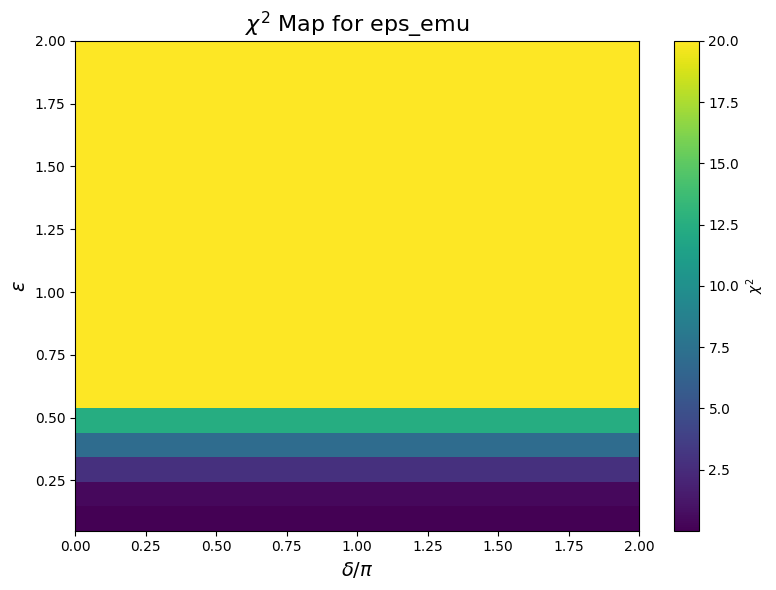

In [133]:
import matplotlib.pyplot as plt

#Normalize by pi
delta_pi_norm = delta_vals/(np.pi)

plt.figure(figsize=(8,6))

# Get edges
eps_edges = np.linspace(eps_vals[0], eps_vals[-1], len(eps_vals)+1)
delta_edges = np.linspace(delta_pi_norm[0], delta_pi_norm[-1], len(delta_pi_norm)+1)

pcm = plt.pcolormesh(delta_edges, eps_edges, chi2_map, shading='auto', cmap='viridis', vmax = 20)
plt.colorbar(pcm, label=r'$\chi^2$')

plt.xlabel(r'$\delta / \pi$', fontsize = 14)
plt.ylabel(r'$\epsilon$' , fontsize = 14)
plt.title(r'$\chi^2$ Map for eps_emu', fontsize = 16)

plt.tight_layout()
plt.show()

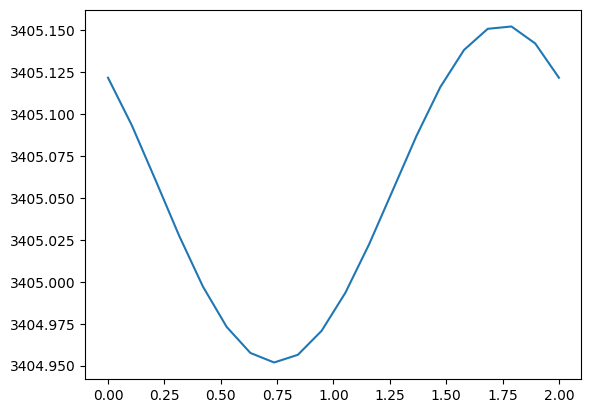

In [129]:
#Sanity check. Does varying delta create a sinusoidal pattern at a given epsilon?

deltas = np.linspace(0,2*np.pi, 20)
df_rand = RandomSampling(df)
eventList = []

for delta in deltas:
    nsiDict = Make_NSI_Dict('eps_emu', 0.25, delta)
    events = Get_Expected(df_rand, 1, 1, nsiDict)
    eventList.append(events)

eventArray = np.array(eventList)
delta_norm = deltas/(np.pi)

plt.plot(delta_norm , eventArray)